In [1]:
import pandas as pd
import subprocess
import os
import re
from tqdm.notebook import tqdm
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import random as rd

In [2]:
df = pd.read_csv('../../dataset/OpenPart.csv')
df.head()

,Case,Sample 1,Sample 2,Sample 3
0,00000072_000.png,1,5,1
1,00000150_002.png,5,5,3
2,00000181_061.png,4,4,3
3,00000211_019.png,4,4,2
4,00000211_041.png,3,5,2


In [3]:
def rename_file(num):
    def fun(row):
        row[0] = f'dataset/sample_{num}/{row[0]}'
        row[0] = row[0].replace('.png', f'_s{num}.png')
        return row
    return fun

def rename_expert_file(file_name):
    file_name = 'dataset/Expert/' + file_name[:-4] + '_expert.png'
    return file_name

In [4]:
df_s1 = df.iloc[:,[0,1]]
df_s1 = df_s1.rename(columns={"Case": "pred_path", "Sample 1": "review"})
df_s1['pred_path'].apply(rename_expert_file)
df_s1['true_mask'] = df_s1['pred_path'].apply(rename_expert_file)
df_s1 = df_s1.apply(rename_file(1), axis=1)
df_s1 = df_s1[['true_mask', 'pred_path', 'review']]
# df_s1

In [5]:
df_s2 = df.iloc[:,[0,1]]
df_s2 = df_s2.rename(columns={"Case": "pred_path", "Sample 1": "review"})
df_s2['true_mask'] = df_s2['pred_path'].apply(rename_expert_file)
df_s2 = df_s2.apply(rename_file(2), axis=1)
df_s2 = df_s2[['true_mask', 'pred_path', 'review']]
# df_s2

In [6]:
df_s3 = df.iloc[:,[0,1]]
df_s3 = df_s3.rename(columns={"Case": "pred_path", "Sample 1": "review"})
df_s3['true_mask'] = df_s3['pred_path'].apply(rename_expert_file)
df_s3 = df_s3.apply(rename_file(3), axis=1)
df_s3 = df_s3[['true_mask', 'pred_path', 'review']]
# df_s3

In [16]:
type_dict = [
    DICE, JACRD, AUC, KAPPA, RNDIND, ADJRIND, ICCORR, VOLSMTY, MUTINF,
HDRFDST, MAHLNBS, VARINFO, GCOERR, PROBDST, SNSVTY, SPCFTY, PRCISON,
FMEASR, ACURCY, FALLOUT, TP, FP, TN, FN, REFVOL, SEGVOL]

In [17]:
new_df = pd.concat([df_s1, df_s2, df_s3]).reset_index(drop=True)

new_df['true_mask_pixels'] = 0
new_df['pred_mask_pixels'] = 0

for t in type_dict:
    new_df[t] = 0

In [18]:
def calculate(true_mask, pred_path, debug=False):    
    cmd_metrics = 'DICE,JACRD,AUC,KAPPA,RNDIND,ADJRIND,ICCORR,VOLSMTY,MUTINF,MAHLNBS,HDRFDST,VARINFO,GCOERR,PROBDST,SNSVTY,SPCFTY,PRCISON,FMEASR,ACURCY,FALLOUT,TP,FP,TN,FN,REFVOL,SEGVOL'
    
    metrics = subprocess.run(['./scripts/evaluate',
                              true_mask,
                              pred_path,
                             '-use', cmd_metrics],
                              cwd=os.path.realpath(os.path.join(os.getcwd(), '..', '..')),
                              capture_output=True)
    
    metrics = metrics.stdout.decode("utf-8").strip()
    if debug:
        print(metrics)
    metrics = re.findall(r"([A-Z]+)\s+=\s([\.\d]+)\s+[\w\(\)\-,\s]+\s?$",
                         metrics, re.MULTILINE)
    
    return metrics

In [19]:
def calc_pixels(path):
    img = Image.open(f'../../{path}').convert('L')
    np_img = np.array(img)
    np_img[np_img > 0] = 1
    return np.count_nonzero(np_img)

In [20]:
for i in tqdm(new_df.index, ncols='100%'):
    true_mask = new_df.loc[i, ['true_mask']][0]
    pred_path = new_df.loc[i, ['pred_path']][0]
    metrics = calculate(true_mask, pred_path)
    
    for metric_name, value in metrics:
        new_df.loc[i,[metric_name]] = value
        
    new_df.loc[i,['true_mask_pixels']] = calc_pixels(true_mask)
    new_df.loc[i,['pred_mask_pixels']] = calc_pixels(pred_path)
    

In [22]:
new_df

,true_mask,pred_path,review,true_mask_pixels,pred_mask_pixels,DICE,JACRD,AUC,KAPPA,RNDIND,...,PRCISON,FMEASR,ACURCY,FALLOUT,TP,FP,TN,FN,REFVOL,SEGVOL
0,dataset/Expert/00000072_000_expert.png,dataset/sample_1/00000072_000_s1.png,1,0,2121,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,dataset/Expert/00000150_002_expert.png,dataset/sample_1/00000150_002_s1.png,5,2729,959,0.520065,0.351411,0.675705,0.519415,0.996630,...,1.000000,0.520065,0.998312,0.000000,959,0,1045847,1770,2729,959
2,dataset/Expert/00000181_061_expert.png,dataset/sample_1/00000181_061_s1.png,4,62059,173279,0.519559,0.350949,0.935726,0.473689,0.807597,...,0.352818,0.519559,0.892172,0.113676,61136,112143,874374,923,62059,173279
3,dataset/Expert/00000211_019_expert.png,dataset/sample_1/00000211_019_s1.png,4,138819,251580,0.708670,0.548791,0.936005,0.648735,0.806597,...,0.549853,0.708670,0.891534,0.124482,138332,113248,796509,487,138819,251580
4,dataset/Expert/00000211_041_expert.png,dataset/sample_1/00000211_041_s1.png,3,124276,285638,0.562957,0.391747,0.872117,0.476487,0.716678,...,0.403945,0.562957,0.829149,0.184200,115382,170256,754044,8894,124276,285638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,dataset/Expert/00011237_006_expert.png,dataset/sample_3/00011237_006_s3.png,3,39847,70040,0.519079,0.350511,0.837288,0.494596,0.904282,...,0.407196,0.519079,0.949601,0.041161,28520,41520,967209,11327,39847,70040
176,dataset/Expert/00011269_019_expert.png,dataset/sample_3/00011269_019_s3.png,1,3351,60618,0.000000,0.000000,0.471002,0,0.885432,...,0.000000,0.000000,0.938994,0.057995,0,60618,984607,3351,3351,60618
177,dataset/Expert/00011355_011_expert.png,dataset/sample_3/00011355_011_s3.png,4,39493,195195,0.304123,0.179331,0.872778,0.257612,0.737018,...,0.182827,0.304123,0.844252,0.158072,35687,159508,849575,3806,39493,195195
178,dataset/Expert/00011450_000_expert.png,dataset/sample_3/00011450_000_s3.png,4,49848,9603,0.315453,0.187263,0.593943,0.304776,0.925389,...,0.976466,0.315453,0.961188,0.000226,9377,226,998502,40471,49848,9603


In [23]:
mistakes = new_df[(new_df['review'] == 5) & (new_df['true_mask_pixels'] == 0) & (new_df['pred_mask_pixels'] != 0)]

mistakes[['true_mask', 'pred_path', 'review', 'true_mask_pixels', 'pred_mask_pixels']]

,true_mask,pred_path,review,true_mask_pixels,pred_mask_pixels
75,dataset/Expert/00002597_000_expert.png,dataset/sample_2/00002597_000_s2.png,5,0,2020
91,dataset/Expert/00005215_000_expert.png,dataset/sample_2/00005215_000_s2.png,5,0,3363
119,dataset/Expert/00011502_001_expert.png,dataset/sample_2/00011502_001_s2.png,5,0,156024
179,dataset/Expert/00011502_001_expert.png,dataset/sample_3/00011502_001_s3.png,5,0,140561


<AxesSubplot:>

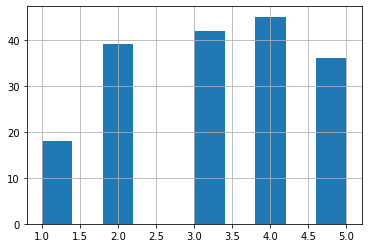

In [26]:
new_df['review'].hist()

In [27]:
def augment_data(df, max_count=42):
    n_iter = 0
    childs = []
    
    for rand_review in [1,2,3,4,5]:
        review_len = 0
        
        while review_len < max_count:
            parents = df[df['review'] == rand_review].sample(2)

            parents_contain_zeroes = np.any(parents.iloc[:,:2].to_numpy() == 0)

            if parents_contain_zeroes:
                continue

            cross = [0, 0]
            cross.extend(np.random.randint(2, size=5))

            childs_dict = {}

            for i, feature in enumerate(features):
                childs_dict[feature] = [
                    parents.iloc[cross[i]][feature],
                    parents.iloc[int(cross[i] != 1)][feature],
                ]

            childs_dict['review'] = [rand_review, rand_review]

            if isinstance(childs, list):
                childs = pd.DataFrame(data=childs_dict)
            else:
                childs = pd.concat([
                    childs,
                    pd.DataFrame(data=childs_dict)
                ])
            
            review_len = childs[childs['review'] == rand_review].shape[0] + df[df['review'] == rand_review].shape[0]
    return pd.concat([df, childs]).reset_index(drop=True).sample(frac=1)

In [36]:
from sklearn.model_selection import train_test_split
from catboost.utils import eval_metric
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

# Train classificator
## 1, 5 vs 2, 3, 4

In [71]:
def change_review_code(row):
    move_left = rd.randint(0,1)
    if row[-1] == 3 and move_left:
        row[-1] = 2
    elif row[-1] == 4:
        row[-1] = 3
    elif row[-1] == 5:
        row[-1] = 4
    return row

In [83]:
source_results = []
results = []
models = []

target = 'review'
features = ['true_mask_pixels', 'pred_mask_pixels', 'DICE', 'TP', 'FP', 'REFVOL', 'MUTINF']

df = new_df[features + [target]]
# df.loc[mistakes.index, target] = 1
df = df.apply(change_review_code, axis=1)

for _ in tqdm(range(100)):
    df_train, df_test = train_test_split(df, train_size=0.5, stratify=df[target])
    
#     df_train = augment_data(df_train)
    
#     display(df_train['review'].hist())
#     plt.show()

    train_pool = Pool(df_train[features], label=df_train[target])
    test_pool = Pool(df_test[features], label=df_test[target])

    cb_mae = CatBoostRegressor(loss_function='MAE', silent=True)
    cb_mae.fit(train_pool, eval_set=test_pool)#, plot=True)
    
    cb_mae_pred = cb_mae.predict(test_pool)
    cb_mae_pred_rint = np.rint(cb_mae.predict(test_pool))
    
    models.append(cb_mae)
    source_results.append(eval_metric(df_test[target].to_numpy(), cb_mae_pred, 'MAE'))
    results.append(eval_metric(df_test[target].to_numpy(), cb_mae_pred_rint, 'MAE'))
    
print('mae_rint max\t', np.amax(results))
print('mae_rint loss\t', np.mean(results))
print('mae_rint min\t', np.amin(results))


mae_rint max	 0.7333327000000006
mae_rint loss	 0.5725550800000004
mae_rint min	 0.41111076666666674


In [84]:
print('mae_rint max\t', np.amax(source_results))
print('mae_rint loss\t', np.mean(source_results))
print('mae_rint min\t', np.amin(source_results))

mae_rint max	 0.7336656556702424
mae_rint loss	 0.6150310994400197
mae_rint min	 0.5178799659814649


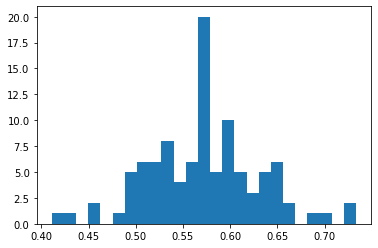

In [85]:
plt.hist(np.reshape(results, (1, -1))[0], bins=25)
plt.show()

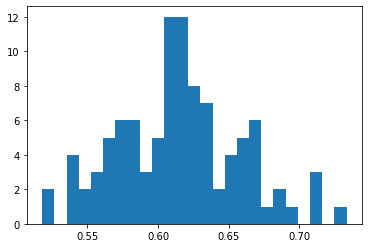

In [86]:
plt.hist(np.reshape(source_results, (1, -1))[0], bins=25)
plt.show()